<a href='https://github.com/SeWonKwon' ><div> <img src ='https://slid-capture.s3.ap-northeast-2.amazonaws.com/public/image_upload/6556674324ed41a289a354258718280d/964e5a8b-75ad-41fc-ae75-0ca66d06fbc7.png' align='left' /> </div></a>


# Task 

**Customer Segmentation** with RFM

* Recency : 가장 최근 상품 구입 일에서 오늘까지의 기간
* Frequency : 상품 구매 횟수
* Monetary Value : 총 구매 금액

# Source 

source : https://github.com/SeWonKwon/ML_training/tree/main/UCI/online_retail

download : https://github.com/SeWonKwon/ML_training/blob/main/UCI/online_retail/data/online_retail.xlsx?raw=true

# Load_data  & import

In [1]:
import pandas as pd

retail_df = pd.read_excel(io='https://github.com/SeWonKwon/ML_training/blob/main/UCI/online_retail/data/online_retail.xlsx?raw=true')

In [2]:
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
df= retail_df.copy()

In [4]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Preprocessing1

## Null handling

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

* 고객 세그멘 테이션을 하는 것이기 때문에 커스터머 아이디가 없는 사람들은 의미가 없다. 

* 하지만, 커스터머 아이디가 없는 사람, 즉, 비회원으로 구매한사람, 들만을 가지고 클러스터링 한다면 또 다른 의미가 있거나 의미를 찾아 낼수 있다. 

이번 Task에서는 CustomerID가 없는 사람은 제거 하기로 한다. 

In [6]:
df[df['Description'].isnull()]['CustomerID'].notnull().sum()

0

Description의 널값은 모두 CustomerID가 없는 값에 포함되므로 CustomerID가 없는 사람을 지우면 위의 모든 널값은 아래와 같이 없어진다.

In [7]:
df = df[df['CustomerID'].notnull()]

In [8]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
df.shape

(406829, 8)

그다음으로 지워야 할 주문 건수는 주문 한 후에 취소한 것. 즉 주문과 취소주문(1쌍).

공룡책에서는 취소주문만 지웠는데 오류라고 생각한다. 


In [10]:
print(df[df['Quantity']<0 ].shape)
df[df['Quantity']<0 ].head(3)

(8905, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom


In [11]:
df2= df.copy()


In [12]:
df2.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


for i,v in df2.iterrows():
    if v['Quantity']<=0:
        a,b,c = v[['Quantity','UnitPrice','CustomerID']]
        print(a,b,c)


In [13]:
df2['InvoiceNo'] = df2['InvoiceNo'].apply(lambda x : int(str(x).replace('C','')))
del_index_list=[]
for i,v in df2.iterrows():
    if v['Quantity']<=0:
        a,b,c,d,e = v[['Quantity','UnitPrice','CustomerID','StockCode','InvoiceNo']]
#         print(a,b,c)
        con1=df2['Quantity']==abs(a)
        con2=df2['UnitPrice']==b
        con3=df2['CustomerID']==c
        con4=df2['StockCode']==d
        con5=df2['InvoiceNo']<e
        del_index_list += [i]
        if df2[con1&con2&con3&con4&con5].shape[0]>=1:
#             print(i,v)
#             print(df2[con1&con2&con3&con4&con5].index)
            del_index_list += df2[con1&con2&con3&con4&con5].index.tolist()
            

In [14]:
len(del_index_list)

12954

In [15]:
del_index_list= sorted(list(set(del_index_list)))

In [16]:
len(del_index_list)

12787

In [17]:
del_index_list[:10]

[8, 47, 55, 57, 72, 74, 84, 141, 154, 235]

In [18]:
df3 = df.drop(index=del_index_list)
df3.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [19]:
df3[df3['Quantity']<=0].shape

(0, 8)

In [20]:
df3.shape

(394042, 8)

df3는 취소주문과 원주문, 커스터머 아이디가 없는 것을 지웠다. 

영국만 나누어 보도록 하자(영국이 91%이상을 차지함)

In [21]:
retail_df = df3[df3['Country']=='United Kingdom']
retail_df.Country.unique()

array(['United Kingdom'], dtype=object)

'UnitPrice'==0 인 주문건을 지워야 한다. 아마도 재고가 없거나 오류로 발생한 주문건인듯 하다. 

In [22]:
retail_df = retail_df[retail_df['UnitPrice']>0]

In [23]:
retail_df.shape

(351124, 8)

## RFM 기반 data preprocessing

In [25]:
retail_df['sale_amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [26]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7472
14096    5111
12748    4548
14606    2613
15311    2360
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    189767.53
17511     81754.38
16684     65920.12
14096     65164.79
Name: sale_amount, dtype: float64


주문번호(InvoiceNo) + 상품코드(StockCode) 레벨의 식별자로 되어 있다. 

In [30]:
invoice_scode=retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count()

In [27]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028633367511352

In [29]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count() != 1

InvoiceNo  StockCode
536365     21730        False
           22752        False
           71053        False
           84029E       False
           84029G       False
                        ...  
581585     84946        False
581586     20685        False
           21217        False
           22061        False
           23275        False
Name: InvoiceNo, Length: 341350, dtype: bool

In [33]:
invoice_scode[retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count() != 1]

InvoiceNo  StockCode
536381     71270        2
536409     21866        2
           22111        2
           22866        2
           22900        2
                       ..
581538     23318        2
           23343        2
           23349        2
           84380        2
           35004B       2
Name: InvoiceNo, Length: 8871, dtype: int64

In [56]:
(invoice_scode[retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count() != 1]==20).sum()

1

In [51]:
test_df = retail_df.copy()
test_df['In_St'] = test_df['InvoiceNo'].astype(str)+test_df['StockCode'].astype(str)

In [54]:
test_df.sort_values(by='In_St')['In_St'].value_counts()

55552422698    20
55552422697    12
57286122775     8
572344M         7
57828923395     7
               ..
56471221843     1
56678122654     1
54662422621     1
58150122447     1
56073623321     1
Name: In_St, Length: 341350, dtype: int64

In [71]:
dup_si = test_df.sort_values(by='In_St')['In_St'].value_counts()

In [69]:
test_df.shape

(351124, 10)

In [74]:
dup_list = dup_si[test_df.sort_values(by='In_St')['In_St'].value_counts()>=20].index.tolist()
len(dup_list)

1

In [75]:
test_df[test_df['In_St'].isin(dup_list)].sort_values('In_St')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount,In_St
213176,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213206,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213205,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213204,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213203,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213202,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213201,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213200,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213199,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698
213198,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,55552422698


test_df는 주문번호(InvoiceNo) + 상품코드(StockCode)를 식별자로 쓰고 싶은데 중복되는것이 다수 보여서 중복 되는 것을 확인해 보려고 만들어 보았는데 위처럼 그냥 완전히 중복된 것으로 보인다. 양이 많지 않음으로 우선은 그냥 넘어가야 할듯 하다. 

RFM으로 cust_df를 생성해보자.

In [86]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()

aggregations = {'InvoiceDate' : 'max', 
                'InvoiceNo' : 'count',
                'sale_amount': 'sum'}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
cust_df.head(3)

,InvoiceDate,InvoiceNo,sale_amount
CustomerID,,,
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4548,31981.32
12749,2011-12-06 09:56:00,199,4090.88


In [87]:
cust_df.columns = ['Recency', 'Frequency', 'Monetary']
cust_df.reset_index(inplace=True)

In [88]:
cust_df.head(1)

,CustomerID,Recency,Frequency,Monetary
0,12747,2011-12-07 14:34:00,103,4196.01


In [89]:
cust_df['Recency'] = cust_df['Recency'].max() - cust_df['Recency']
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12747,1 days 22:15:00,103,4196.01
1,12748,0 days 00:29:00,4548,31981.32
2,12749,3 days 02:53:00,199,4090.88


In [90]:
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days + 1)
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12747,2,103,4196.01
1,12748,1,4548,31981.32
2,12749,4,199,4090.88
3,12820,3,59,942.34
4,12821,214,6,92.72
...,...,...,...,...
3907,18280,278,10,180.60
3908,18281,181,7,80.82
3909,18282,8,12,178.05
3910,18283,4,756,2094.88


In [91]:
cust_df.min()

CustomerID    12747.0
Recency           1.0
Frequency         1.0
Monetary          2.9
dtype: float64

이것으로 기본적인 RFM 전처리는 끝~



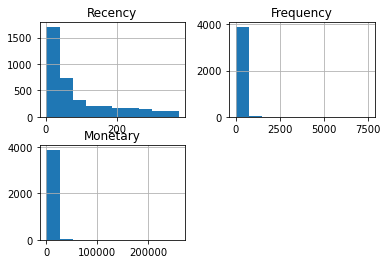

In [94]:
cust_df.iloc[:,1:].hist();

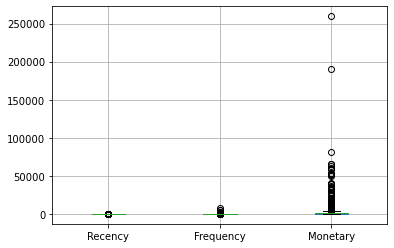

In [96]:
cust_df.iloc[:,1:].boxplot();

In [95]:
cust_df.iloc[:,1:].describe()

,Recency,Frequency,Monetary
count,3912.000000,3912.000000,3912.000000
mean,92.429192,89.755624,1765.505985
std,99.757925,213.634324,6702.438578
min,1.000000,1.000000,2.900000
25%,18.000000,16.000000,296.555000
50%,51.000000,41.000000,640.450000
75%,143.250000,99.000000,1551.240000
max,374.000000,7472.000000,259657.300000


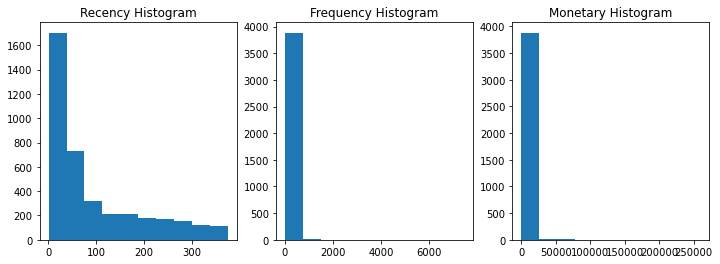

In [98]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary']);

# 모델링 

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.583


In [106]:
stantrns_df = pd.DataFrame(data=X_features_scaled, columns=['Recency','Frequency','Monetary'] )
stantrns_df.head(3)

,Recency,Frequency,Monetary
0,-0.906602,0.062003,0.362676
1,-0.916628,20.871245,4.508758
2,-0.886551,0.511427,0.346989


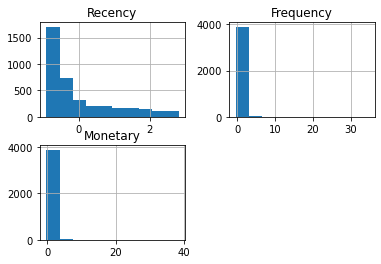

In [108]:
stantrns_df.hist();

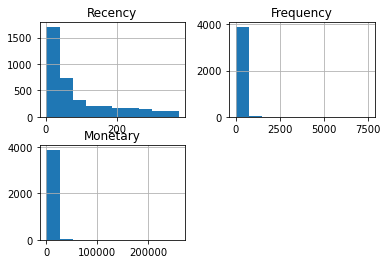

In [94]:
cust_df.iloc[:,1:].hist();

scale은 다소 편차가 줄어 들었지만, 왜곡도는 향상 되지 않았다. 

In [100]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [119]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend +' '+ str(round(label_df.shape[0]/dataframe.shape[0]*100,1))+'%')

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

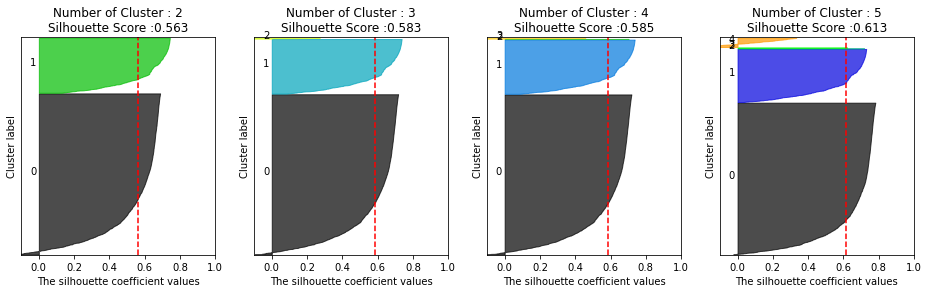

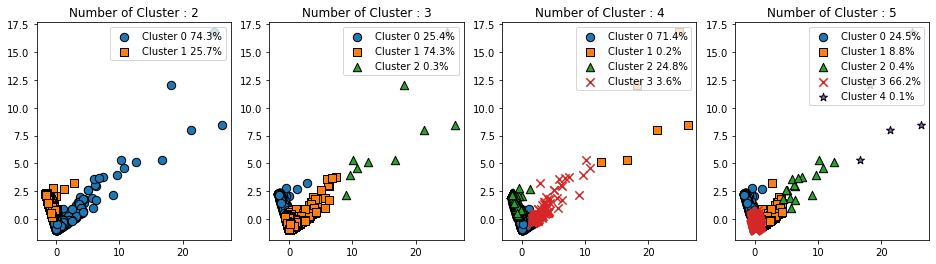

In [120]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

2,3,4 에서는 70%이상이 한쪽으로 몰려있고, 5에서도 66%이상이 한쪽으로 군집화가 된것을 알수 있다. 

가장 낮은 쪽에 대부분의 그룹이 모여 있는것을 확인 할수 있는데, 

지나치게 일반적인 군집화 결과를 도출하게 된다. 

판매처 특성상 항상 모여있는 곳이 있기 마련인데, 우리의 목표는 간단한 분석만으로 아는 것을 확인하는 것이 아니라, 무언가 새로운 관점을 찾기 위함이다. 

가장 큰 이유는 왜곡된 데이터 값 때문인데 이를 해결하려면 log 변환을 사용해 보자.

In [123]:
cust_log_df = pd.DataFrame()
cust_log_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_log_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_log_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

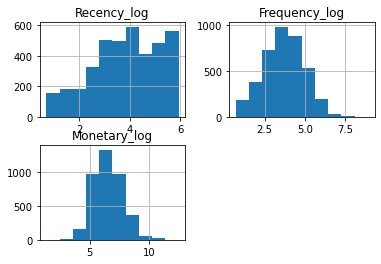

In [125]:
cust_log_df.hist();

In [128]:
X_features = cust_log_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.304


In [129]:
log_stantrns_df = pd.DataFrame(data=X_features_scaled, columns=['Recency','Frequency','Monetary'] )
log_stantrns_df.head(3)

,Recency,Frequency,Monetary
0,-2.035466,0.737299,1.461395
1,-2.337718,3.734474,3.100366
2,-1.654674,1.256037,1.440922


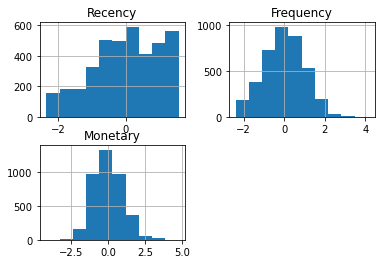

In [130]:
log_stantrns_df.hist();

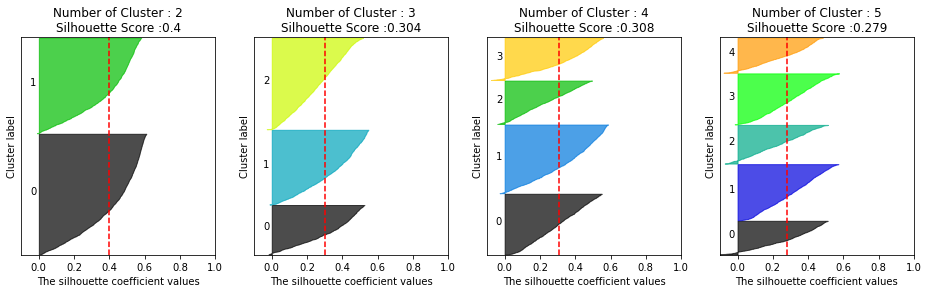

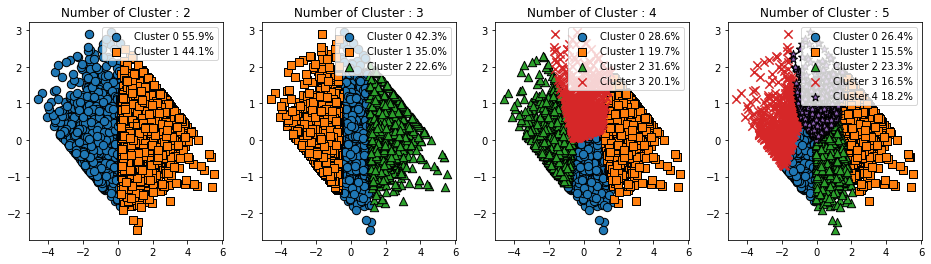

In [131]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

**Reference**

* <a href='https://github.com/SeWonKwon' ><div> <img src ='https://slid-capture.s3.ap-northeast-2.amazonaws.com/public/image_upload/6556674324ed41a289a354258718280d/964e5a8b-75ad-41fc-ae75-0ca66d06fbc7.png' align='left' /> </div></a>

<br>

* 파이썬 머신러닝 완벽 가이드, 권철민

